# 4. Evaluation Metrics for Classification

In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [71]:
df = pd.read_csv('../data/telco_customer_churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [72]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [73]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [74]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/oogi-poh-poh/miniconda3/envs/datascience/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


### 4.1 Evaluation metrics: session overview  
  
**Metric** - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [75]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.801277501774308)

#### 4.2 Accuracry

In [76]:
len(y_val)

1409

In [77]:
(y_val == churn_decision).mean()


np.float64(0.801277501774308)

In [78]:
from sklearn.metrics import accuracy_score

In [79]:
accuracy_score(y_val, y_pred >= 0.5)

0.801277501774308

In [80]:
thresholds = np.linspace(0, 1, 21)

thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)



0.00 0.274
0.05 0.509
0.10 0.598
0.15 0.664
0.20 0.707
0.25 0.737
0.30 0.759
0.35 0.766
0.40 0.780
0.45 0.793
0.50 0.801
0.55 0.798
0.60 0.797
0.65 0.784
0.70 0.765
0.75 0.744
0.80 0.730
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


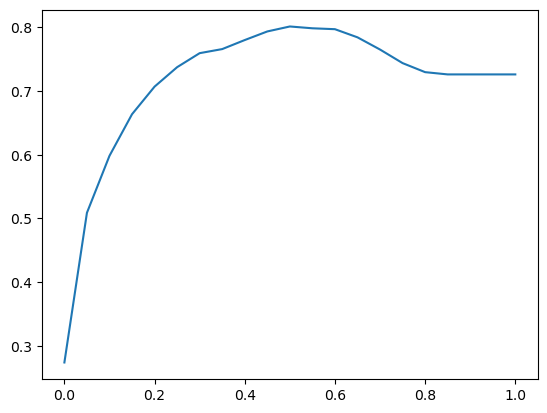

In [81]:
plt.plot(thresholds, scores)

In [82]:
from collections import Counter

In [83]:
Counter(y_pred < 1)

Counter({np.True_: 1409})

In [84]:
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

In [85]:
y_val.mean()

np.float64(0.2739531582682754)

In [86]:
# Accurracy predicting all not churning
1 - y_val.mean()

np.float64(0.7260468417317246)

### 4.3 Confusion table

In [87]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [88]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [89]:
tp  = (predict_positive & actual_positive).sum()
tn  = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [90]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix


array([[915, 108],
       [172, 214]])

In [91]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.08],
       [0.12, 0.15]])

### 4.4 Precision and Recall

In [92]:
p = tp / (tp + fp)
p

np.float64(0.6645962732919255)

In [93]:
r = tp /(tp + fn)
r

np.float64(0.5544041450777202)

### 4.5 - ROC Curves 

In [94]:
fpr = fp / (fp+tn)
fpr

np.float64(0.10557184750733138)

In [95]:
tnr = tp /(tp+fn)
tnr

np.float64(0.5544041450777202)

In [96]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [97]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [98]:
# review every 10th record
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,367,547,19,476
20,0.2,334,361,52,662
30,0.3,291,244,95,779
40,0.4,253,177,133,846
50,0.5,214,108,172,915
60,0.6,153,53,233,970
70,0.7,69,14,317,1009
80,0.8,5,0,381,1023
90,0.9,0,0,386,1023


In [99]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

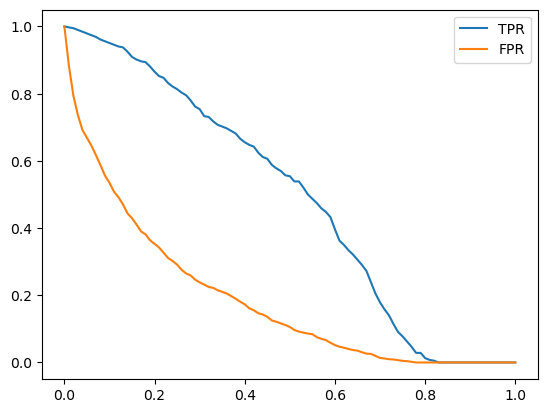

In [100]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Random Model

In [101]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [102]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [103]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [104]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

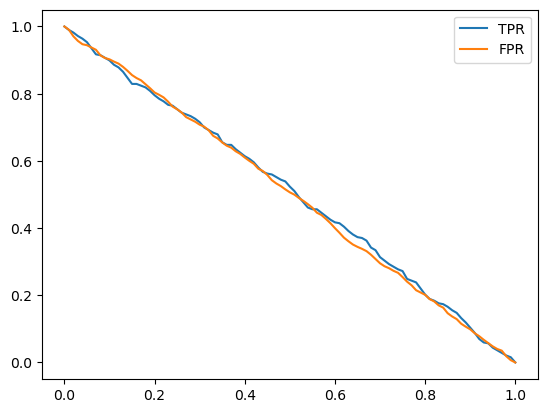

In [105]:


plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()



### Ideal model

In [ ]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [111]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [109]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [112]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

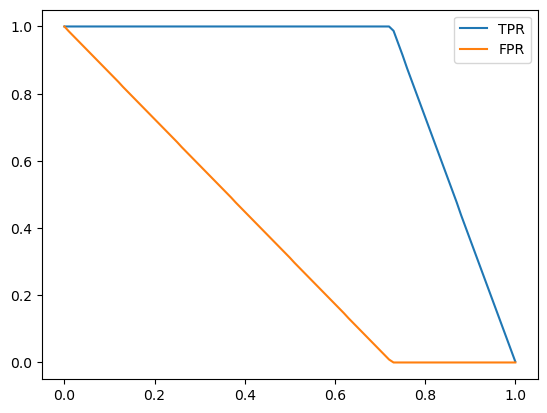

In [113]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

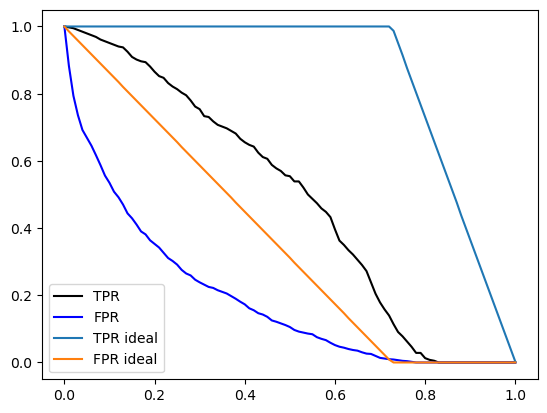

In [114]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()


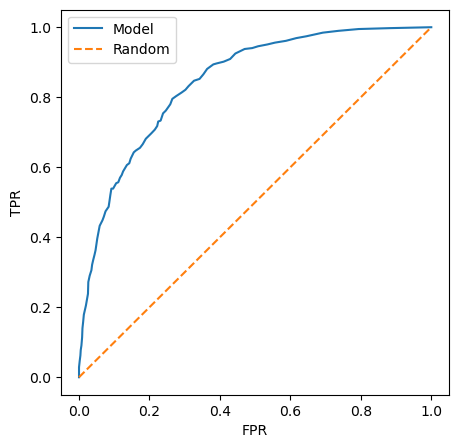

In [115]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()


In [116]:
from sklearn.metrics import roc_curve

In [117]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

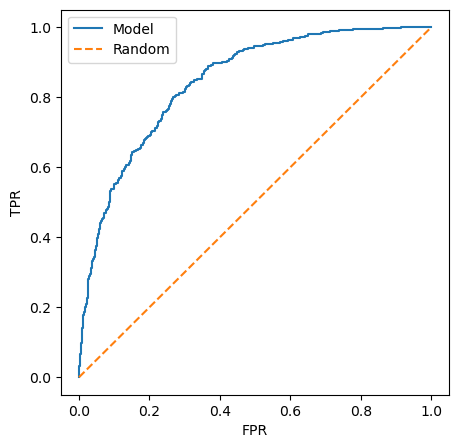

In [118]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### 4.6 ROC AUC

* Area under the ROC curve - useful metric
* Interpretation of AUC

In [119]:
from sklearn.metrics import auc

In [120]:
auc(fpr, tpr)

0.8445038720820102

In [121]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [122]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)



0.8445038720820102

In [123]:
from sklearn.metrics import roc_auc_score

In [124]:
roc_auc_score(y_val, y_pred)

0.8445038720820102

In [ ]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(y_pred[y_val == 1]), size=n)
neg_ind = np.random.randint(0, len(y_pred[y_val == 0]), size=n)

# Probability that a randomly selected positive predicted sample is greater
#   a negative predicted sample.
#  -- Prob( score(xi | +) > score(xi | -))
(y_pred[y_val == 1][pos_ind] > y_pred[y_val == 0][neg_ind]).mean()



np.float64(0.8466)

## 4.7 Cross-Validation  


In [154]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [128]:
dv, model = train(df_train, y_train, C=0.001)

In [129]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [ ]:
y_pred = predict(df_val, dv, model)

In [131]:
from sklearn.model_selection import KFold

In [139]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [140]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [141]:
len(train_idx)/len(df_full_train), len(val_idx)/len(df_full_train)

(0.8998935037273695, 0.10010649627263046)

In [142]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [146]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

score = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values


    dv, model = train(df_train, y_train, C=0.001)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    score.append(auc)

In [151]:
print('%.3f, +- %.3f' % (np.mean(score), np.std(score)))

0.826, +- 0.012


In [160]:
n_splits = 5

score_stats = {}

for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    #print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
    score_stats[C] = {"mean": np.mean(scores), "std": np.std(scores)}

/home/oogi-poh-poh/miniconda3/envs/datascience/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/oogi-poh-poh/miniconda3/envs/datascience/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    htt

In [163]:
pd.DataFrame(score_stats)

,0.001,0.010,0.100,0.500,1.000,5.000,10.000
mean,0.825068,0.840005,0.841871,0.841975,0.841997,0.841948,0.841933
std,0.009283,0.008227,0.007349,0.006983,0.006926,0.006906,0.006856
